# 1d3v electron hybrid code for R/L-waves with stationary ions and dipole background field

## 1. The model
The electron hybrid model for cold electrons with linearized fluid equations and hot kinetic electrons (Vlasov equation) reads

\begin{align}
&\frac{\partial\tilde{\mathbf{j}}_\mathrm{c}}{\partial t}=\epsilon_0\Omega_\mathrm{pe}^2\tilde{\mathbf{E}}+\tilde{\mathbf{j}}_\mathrm{c}\times\mathbf{\Omega}_\mathrm{ce}(\mathbf{x}),\\
&\frac{\partial f_\mathrm{h}}{\partial t}+\mathbf{v}\cdot\nabla f_\mathrm{h}+\frac{q_\mathrm{e}}{m_\mathrm{e}}(\mathbf{E}+\mathbf{v}\times\mathbf{B})\cdot\nabla_\mathbf{v}f_\mathrm{h}=0,\\
&\frac{\partial \tilde{\mathbf{B}}}{\partial t}=-\nabla\times\tilde{\mathbf{E}},\\
&\frac{1}{c^2}\frac{\partial \tilde{\mathbf{E}}}{\partial t}=\nabla\times\tilde{\mathbf{B}}-\mu_0\tilde{\mathbf{j}}_\mathrm{c}-\mu_0q_\mathrm{e}\int\mathbf{v}\tilde{f}_\mathrm{h}\,\mathrm{d}^3\mathbf{v},
\end{align}

where $\mathbf{\Omega}_\mathrm{ce}(\mathbf{x})=q_\mathrm{e}\mathbf{B}_0(\mathbf{x}/m_\mathrm{e}$ is the oriented electron cyclotron frequency corresponding to the background field $\mathbf{B}_0=\mathbf{B}_0(\mathbf{x})$ and $\Omega_{\mathrm{pe}}^2=n_{\mathrm{c}0}e^2/\epsilon_0m_\mathrm{e}$ the plasma frequency of the cold electrons. Here, only wave propagation parallel to the background magnetic field $\mathbf{B}_0=\mathbf{B}_0(\mathbf{x})$ is considered, i.e. $\textbf{k}=k\textbf{e}_z$. Therefore the nabla operator is simply $\nabla=\textbf{e}_z\partial_z$. The background magnetic field is $B_{0z}(z)=B_0(1+\xi z^2)$ with the $x$- and $y$- components such that $\nabla\cdot\mathbf{B}_0=0$, i.e. $B_{0x}=-B_0xz\xi$ and $B_{0y}=-B_0yz\xi$.

We use absorbing boundary conditions for all the unknown fields ($\tilde{E}_x$, $\tilde{E}_y$, $\tilde{B}_x$, $\tilde{B}_y$, $\tilde{j}_{\mathrm{c}x}$, $\tilde{j}_{\mathrm{c}y}$) by multiplying with a masking function near the domain boundaries.

# 1. The code

In [1]:
import numpy as np
import time
from copy import deepcopy
import Utilitis_HybridCode as utils




# ... saving data? (save = 0: no, save = 1: yes). If yes, name directory
save = 0
title = 'test.txt' 
# ...

# ... save only every saving_step-th time step
saving_step = 1
# ...                    



# ... physical parameters
eps0 = 1.0                         # ... vacuum permittivity
mu0 = 1.0                          # ... vacuum permeability
c = 1.0                            # ... speed of light
qe = -1.0                          # ... electron charge
me = 1.0                           # ... electron mass
B0z = 1.0                          # ... minimum of background magnetic field in z-direction at z = Lz/2
wce = qe*B0z/me                    # ... electron cyclotron frequency (minimum)
wpe = 5*np.abs(wce)                # ... cold electron plasma frequency
nuh = 6e-3                         # ... ratio of cold/hot electron densities (nh/nc)
nh = nuh*wpe**2                    # ... hot electron density
wpar = 0.2*c                       # ... parallel thermal velocity of energetic particles
wperp = 0.53*c                     # ... perpendicular thermal velocity of energetic particles

xi = 8.62e-5                       # ... inhomogeneity factor of background magnetic field

bcs_p = 2                          # ... particle boundary conditions (1: periodic, 2: reflecting)
bcs_f = 2                          # ... boundary conditions for fields (1: periodic, 2: hom. Dirichlet)
bcs_d = 1                          # ... boundary condition for damping (1: on, 0: off)
bcs_g = 1                          # ... boundary condition for distribution function (1: field line dependence, 0: uniform)
# ...



# ... parameters for initial conditions
k = 2                              # ... wavenumber of initial wave field perturbations
ini = 6                            # ... initial conditions for wave fields (3 : sin-perturbation of Bx, 5 : all random, 6 : all zero)
amp = 1e-4                         # ... amplitude of initial wave field perturbations
eps = 0.0                          # ... amplitude of spatial pertubation of distribution function 
# ...



# ... numerical parameters
Lz = 327.7                         # ... total length of z-domain
Nel = 128                          # ... number of elements z-direction
T = 100                            # ... simulation time
dt = 0.1                           # ... time step
p = 3                              # ... degree of B-spline basis
Np = np.int(1e6)                   # ... number of energetic simulation particles 
control = 1                        # ... switch on (1) or off control variate (0)
time_integr = 1                    # ... do time integration (1 : yes, 0: no)

Ld = 0.1*Lz                        # ... length of damping region at each end 
# ...



# ... create parameter list
if bcs_f == 1:
    pa = np.zeros(1*Nel + 5)
elif bcs_f == 2:
    pa = np.zeros(1*(Nel + p) + 5)

pa[0]  = eps0
pa[1]  = mu0
pa[2]  = c
pa[3]  = qe 
pa[4]  = me 
pa[5]  = B0z 
pa[6]  = wce 
pa[7]  = wpe 
pa[8]  = nuh 
pa[9]  = nh 
pa[10] = wpar 
pa[11] = wperp 
pa[12] = k 
pa[13] = ini 
pa[14] = amp 
pa[15] = eps 
pa[16] = Lz 
pa[17] = Nel 
pa[18] = T 
pa[19] = dt 
pa[20] = p 
pa[21] = Np 
pa[22] = control
pa[23] = saving_step

pa[24] = xi
pa[25] = Ld

pa[27] = bcs_p
pa[28] = bcs_f
pa[29] = bcs_d
pa[30] = bcs_g
# ...



# ... discretization parameters and diagnostic values (e.g. energies)
dz = Lz/Nel
el_b = np.linspace(0, Lz, Nel + 1)
# ...


# ... some diagnostic values
Eh_eq = Lz*nh*me/2*(wpar**2 + 2*wperp**2)    # ... equilibrium energetic electron energy

en_B  = np.array([])                         # ... magnetic energy
en_E  = np.array([])                         # ... electric energy
en_jc = np.array([])                         # ... cold plasma energy
en_jh = np.array([])                         # ... energetic electron energy
# ...




# ... system matrices for fluid electrons and electromagnetic fields and definition of background magnetic field B_background
A10 = np.array([0, 0, 0, c**2, 0, 0])
A11 = np.array([0, 0, -c**2, 0, 0, 0])
A12 = np.array([0, -1, 0, 0, 0, 0])
A13 = np.array([1, 0, 0, 0, 0, 0])
A14 = np.array([0, 0, 0, 0, 0, 0])
A15 = np.array([0, 0, 0, 0, 0, 0])
A1 = np.array([A10, A11, A12, A13, A14, A15])

A20 = np.array([0, 0, 0, 0, mu0*c**2, 0])
A21 = np.array([0, 0, 0, 0, 0, mu0*c**2])
A22 = np.array([0, 0, 0, 0, 0, 0])
A23 = np.array([0, 0, 0, 0, 0, 0])
A24 = np.array([-eps0*wpe**2, 0, 0, 0, 0, -wce])
A25 = np.array([0, -eps0*wpe**2, 0, 0, wce, 0])
A2 = np.array([A20, A21, A22, A23, A24, A25])

s = int(np.sqrt(A1.size))

def B_background_z(z):
    return B0z*(1 + xi*(z - Lz/2)**2)

def B_background(x, y, z):
    
    Bx = -x*(z - Lz/2)*B0z*xi
    By = -y*(z - Lz/2)*B0z*xi
    Bz = B0z*(1 + xi*(z - Lz/2)**2)
    
    return np.transpose(np.array([Bx, By, Bz]))
# ...




# ... time integration 
def update(uj, particles, Ep, Bp, dt):
    
    
    # ... save old positions
    zold = deepcopy(particles[:, 0])
    # ...
    
    
    # ... update particle velocities from n-1/2 to n+1/2 with fields at time n and positions from n to n+1 with velocities at n+1/2
    znew, vnew = utils.borisPush(particles, dt, Bp, Ep, qe, me, Lz, bcs_p)
    # ...
    
    
    # ... update weights with control variate
    wnew = w0 - control*Maxwell(vnew[:, 0], vnew[:, 1], vnew[:, 2])/g0
    # ...
    
    
    # ... compute hot electron current densities
    jhnew = utils.hotCurrent(vnew[:, 0:2], 1/2*(znew + zold), wnew, el_b, bsp, qe, c, bcs = bcs_f)
    # ...
     
    
    # ... assemble right-hand side of weak formulation
    Fh[0::s] = -c**2*mu0*jhnew[0::2]
    Fh[1::s] = -c**2*mu0*jhnew[1::2]
    # ...
    
    
    # ... time integration of E,B,jc from n to n+1 with Crank-Nicolson method (use hot current density at n+1/2) 
    ujnew = np.dot(LHSinv, np.dot(RHS, uj) + dt*Fh)
    
    if bcs_d == 1:
        ujnew = np.dot(DAMPblock, ujnew)
    # ...
    
    
    # ... compute fields at particle positions with new fields (wave + background)
    Epnew_xy, Bpnew_xy = utils.fieldInterpolation(znew, el_b, bsp, ujnew, bcs_f)
    
    Bpnew_z = B_background_z(znew)
    rho = -me/qe*np.cross(vnew, np.array([0, 0, 1]))/Bpnew_z[:, None]
    
    Bpnew_xy += B_background(rho[:, 0], rho[:, 1], znew)[:, 0:2]
    # ...
    
    return znew, vnew, wnew, jhnew, ujnew, Epnew_xy, Bpnew_xy, Bpnew_z
# ...





    
# ... initial energetic particle distribution function (perturbed anisotropic Maxwellian)
def fh0(z, vx, vy, vz):

    xiB = 1 - B0z/B_background_z(z)
    xiz = 1 + (wperp**2/wpar**2 - 1)*xiB*bcs_g

    return (1 + eps*np.cos(k*z))*nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - xiz*(vx**2 + vy**2)/(2*wperp**2))
# ...


# ... Maxwellian for control variate
def Maxwell(vx, vy, vz):
    return nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))
# ...


# ... sampling distribution for initial markers
def g_sampling(vx, vy, vz):
    return 1/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))*1/Lz
# ...



# ... masking function to damp wave fields near boundaries (and derivatives)
def damp(z):

    if z <= Ld:
        return np.sin(np.pi*z/(2*Ld))
    elif z >= Lz - Ld:
        return np.sin(np.pi*(Lz - z)/(2*Ld))
    else:
        return 1.0
# ...



# ... create B-spline basis and quadrature grid
bsp, Nbase, quad_points, weights = utils.createBasis(Lz, Nel, p, bcs_f)
# ...


if bcs_d == 1:
    # ... assemble damping matrix
    timea = time.time()

    DAMP = utils.dampingAssembly(bsp, damp, 2)

    timeb = time.time()
    print('time for damping matrix assembly: ' + str(timeb - timea))
    # ...


    # ... assemble block damping matrix
    timea = time.time()

    DAMPblock = np.kron(DAMP, np.identity(6))

    timeb = time.time()
    print('time for block damping matrix assembly: ' + str(timeb - timea))
    # ...



# ... some vectors and matrices for linear system
if bcs_f == 1:
    Nb = Nbase - p                # ... number of degrees of freedom (= number of eq.)
elif bcs_f == 2:
    Nb = Nbase - 2                # ... number of degrees of freedom (= number of eq.)

uj = np.zeros(s*Nb)               # ... coefficients for Galerkin approximation
Fh = np.zeros(s*Nb)               # ... RHS of matrix system

D_tilde = np.zeros((s*Nb, s*Nb))  # ... block background field matrix

u0 = np.zeros((Nb, s))            # ... initial coefficients obtained by L2-projection
# ...





# ... assemble mass, convection and background field matrices (including the boundaries)
timea = time.time()

M, C, D = utils.matrixAssembly(bsp, weights, quad_points, B_background_z, bcs_f)

timeb = time.time()
print('time for matrix assembly: ' + str(timeb - timea))
# ...




# ... assemble initial coefficient vector
if bcs_f == 1:

    timea = time.time()

    for qu in range (0, s):

        def initial(z):
            return utils.IC(z, ini, amp, k, omega = 0)[qu]

        u0[:, qu] = utils.L2proj(bsp, Lz, quad_points, weights, M, initial, bcs_f)

    uj = np.reshape(u0, s*Nb)
    timeb = time.time()
    print('time for intial vector assembly: ' + str(timeb - timea))

elif bcs_f == 2:

    timea = time.time()

    for qu in range (0, s):

        def initial(z):
            return utils.IC(z, ini, amp, k, omega = 0)[qu]

        u0[:, qu] = utils.L2proj(bsp, Lz, quad_points, weights, M,initial, bcs_f)[1:Nbase - 1]

    uj = np.reshape(u0, s*Nb)

    timeb = time.time()
    print('time for intial vector assembly: ' + str(timeb - timea))
# ...





# ... construct block mass, convection and field matrices
timea = time.time()

if bcs_f == 1:

    M_block = np.kron(M, np.identity(6))
    C_tilde = np.kron(C, A1)
    
    for i in range(s):
        for j in range(s):

            if i == 4 and j == 5:
                D_tilde[i::s, j::s] = A2[i, j]*D
            elif i == 5 and j == 4:
                D_tilde[i::s, j::s] = A2[i, j]*D
            else:
                D_tilde[i::s, j::s] = A2[i, j]*M


elif bcs_f == 2:

    M_block = np.kron(M[1:Nbase - 1, 1:Nbase - 1], np.identity(6))
    C_tilde = np.kron(C[1:Nbase - 1, 1:Nbase - 1], A1)
    
    for i in range(s):
        for j in range(s):

            if i == 4 and j == 5:
                D_tilde[i::s, j::s] = A2[i, j]*D[1:Nbase - 1, 1:Nbase - 1]

            elif i == 5 and j == 4:
                D_tilde[i::s, j::s] = A2[i, j]*D[1:Nbase - 1, 1:Nbase - 1]

            else:
                D_tilde[i::s, j::s] = A2[i, j]*M[1:Nbase - 1, 1:Nbase - 1]


timeb = time.time()
print('time for block matrix assembly: ' + str(timeb - timea))
# ...





# ... create particles (z, vx, vy, vz, wk) and sample positions and velocities according to sampling distribution
particles = np.zeros((Np, 5))
particles[:, 0] = np.random.rand(Np)*Lz
particles[:, 1] = np.random.randn(Np)*wperp
particles[:, 2] = np.random.randn(Np)*wperp
particles[:, 3] = np.random.randn(Np)*wpar
# ...




# ... parameters for control variate
g0 = g_sampling(particles[:, 1], particles[:, 2], particles[:, 3])
w0 = fh0(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])/g_sampling(particles[:, 1], particles[:, 2], particles[:, 3])
# ...




# ... initial fields at particle positions
Ep = np.zeros((Np, 3))
Bp = np.zeros((Np, 3))

timea = time.time()

Ep[:, 0:2], Bp[:, 0:2] = utils.fieldInterpolation(particles[:, 0], el_b, bsp, uj, bcs_f)


Bp[:, 2] = B_background_z(particles[:, 0])
rho = -me/qe*np.cross(particles[:, 1:4], np.array([0, 0, 1]))/Bp[:, 2][:, None]

Bp[:, 0:2] += B_background(rho[:, 0], rho[:, 1], particles[:, 0])[:, 0:2]

timeb = time.time()
print('time for initial field interpolation: ' + str(timeb - timea))
# ...




# ... initialize velocities by pushing back by -dt/2 and compute weights
timea = time.time()

particles[:, 1:4] = utils.borisPush(particles, -dt/2, Bp, Ep, qe, me, Lz, bcs_p)[1]
particles[:, 4] = w0 - control*Maxwell(particles[:, 1], particles[:, 2], particles[:, 3])/g0

timeb = time.time()
print('time for initial particle push: ' + str(timeb - timea))
#





# ... compute matrices for field update
timea = time.time()

LHS = M_block + 1/2*dt*C_tilde + 1/2*dt*D_tilde
RHS = M_block - 1/2*dt*C_tilde - 1/2*dt*D_tilde

LHSinv = np.linalg.inv(LHS)

timeb = time.time()
print('time for update matrix computation: ' + str(timeb - timea))
# ...





# ... create data file and save parameters (first row), initial bx coefficients and energies (second row)
if save == 1:
    file = open(title, 'ab')
    np.savetxt(file, np.reshape(pa, (1, 1*Nbase + 5)), fmt = '%1.10e')


if bcs_f == 1:
    en_E  = np.append(en_E, eps0/2*(np.dot(uj[0::s], np.dot(M, uj[0::s])) + np.dot(uj[1::s], np.dot(M, uj[1::s]))))
    en_B  = np.append(en_B, eps0/(2*mu0)*(np.dot(uj[2::s], np.dot(M, uj[2::s])) + np.dot(uj[3::s], np.dot(M, uj[3::s]))))
    en_jc = np.append(en_jc, 1/(2*eps0*wpe**2)*(np.dot(uj[4::s], np.dot(M, uj[4::s])) + np.dot(uj[5::s], np.dot(M, uj[5::s]))))
    en_jh = np.append(en_jh, me/(2*Np)*np.dot(particles[:, 4], particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq)

    bx_save = np.append(deepcopy(uj[2::s]), uj[2])
    
    
    
if bcs_f == 2:    
    en_E  = np.append(en_E, eps0/2*(np.dot(np.array([0] + list(uj[0::s]) + [0]), np.dot(M, np.array([0] + list(uj[0::s]) + [0]))) + np.dot(np.array([0] + list(uj[1::s]) + [0]), np.dot(M, np.array([0] + list(uj[1::s]) + [0])))))
    en_B  = np.append(en_B, eps0/(2*mu0)*(np.dot(np.array([0] + list(uj[2::s]) + [0]), np.dot(M, np.array([0] + list(uj[2::s]) + [0]))) + np.dot(np.array([0] + list(uj[3::s]) + [0]), np.dot(M, np.array([0] + list(uj[3::s]) + [0])))))
    en_jc = np.append(en_jc, 1/(2*eps0*wpe**2)*(np.dot(np.array([0] + list(uj[4::s]) + [0]), np.dot(M, np.array([0] + list(uj[4::s]) + [0]))) + np.dot(np.array([0] + list(uj[5::s]) + [0]), np.dot(M, np.array([0] + list(uj[5::s]) + [0])))))
    en_jh = np.append(en_jh, me/(2*Np)*np.dot(particles[:, 4], particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq)

    bx_save = deepcopy(np.array([0] + list(uj[2::s]) + [0]))

    
if save == 1:    
    data = np.append(bx_save, np.array([en_E[-1], en_B[-1], en_jc[-1], en_jh[-1]]))
    data = np.append(data, 0.)
    np.savetxt(file, np.reshape(data, (1, 1*Nbase + 5)), fmt = '%1.10e')
# ...


# ... measure time for hot current computation
timea = time.time()

test_current = utils.hotCurrent(particles[:, 1:3], particles[:, 0], particles[:, 4], el_b, bsp, qe, c, bcs = bcs_f)

timeb = time.time()
print('time for hot current computation: ' + str(timeb - timea))
# ...



# ... time integration
if time_integr == 1:
    
    print('start time integration! (number of time steps : ' + str(int(T/dt)) + ')')
    time_step = 0

    while True:

        try:
            if time_step*dt >= T:
                if save == 1:
                    file.close()
                break
            
            if time_step%50 == 0:
                print('time steps finished: ' + str(time_step))

            particles[:, 0], particles[:, 1:4], particles[:, 4], jh, uj, Ep[:, 0:2], Bp[:, 0:2], Bp[:, 2] = update(uj, particles, Ep, Bp, dt)

            if time_step%saving_step == 0:
                
                if bcs_f == 1:
                    en_E  = np.append(en_E, eps0/2*(np.dot(uj[0::s], np.dot(M, uj[0::s])) + np.dot(uj[1::s], np.dot(M, uj[1::s]))))
                    en_B  = np.append(en_B, eps0/(2*mu0)*(np.dot(uj[2::s], np.dot(M, uj[2::s])) + np.dot(uj[3::s], np.dot(M, uj[3::s]))))
                    en_jc = np.append(en_jc, 1/(2*eps0*wpe**2)*(np.dot(uj[4::s], np.dot(M, uj[4::s])) + np.dot(uj[5::s], np.dot(M, uj[5::s]))))
                    en_jh = np.append(en_jh, me/(2*Np)*np.dot(particles[:, 4], particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq)

                    bx_save = np.vstack((bx_save, np.append(deepcopy(uj[2::s]), uj[2])))
    
    
                if bcs_f == 2:    
                    en_E  = np.append(en_E, eps0/2*(np.dot(np.array([0] + list(uj[0::s]) + [0]), np.dot(M, np.array([0] + list(uj[0::s]) + [0]))) + np.dot(np.array([0] + list(uj[1::s]) + [0]), np.dot(M, np.array([0] + list(uj[1::s]) + [0])))))
                    en_B  = np.append(en_B, eps0/(2*mu0)*(np.dot(np.array([0] + list(uj[2::s]) + [0]), np.dot(M, np.array([0] + list(uj[2::s]) + [0]))) + np.dot(np.array([0] + list(uj[3::s]) + [0]), np.dot(M, np.array([0] + list(uj[3::s]) + [0])))))
                    en_jc = np.append(en_jc, 1/(2*eps0*wpe**2)*(np.dot(np.array([0] + list(uj[4::s]) + [0]), np.dot(M, np.array([0] + list(uj[4::s]) + [0]))) + np.dot(np.array([0] + list(uj[5::s]) + [0]), np.dot(M, np.array([0] + list(uj[5::s]) + [0])))))
                    en_jh = np.append(en_jh, me/(2*Np)*np.dot(particles[:, 4], particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq)

                    bx_save = np.vstack((bx_save, deepcopy(np.array([0] + list(uj[2::s]) + [0]))))

                    
                # ... add data to file
                if save == 1:    
                    data = np.append(bx_save[-1], np.array([en_E[-1], en_B[-1], en_jc[-1], en_jh[-1]]))
                    data = np.append(data, (time_step + 1)*dt)
                    np.savetxt(file, np.reshape(data, (1, 1*Nbase + 5)), fmt = '%1.10e')
                # ...


            time_step += 1
        except KeyboardInterrupt:
            print('Pausing...  (Hit ENTER to continue, type quit to exit.)')
            try:
                

                response = input()
                if response == 'quit':
                    break
                print('Resuming...')

                file = open(title, 'ab')
            except KeyboardInterrupt:
                print('Resuming...')
                continue
    
    
    if save == 1:
        file.close()
# ...

time for damping matrix assembly: 0.4783449172973633
time for block damping matrix assembly: 0.01001429557800293
time for matrix assembly: 1.3704235553741455
time for intial vector assembly: 1.872962236404419
time for block matrix assembly: 0.020316123962402344
time for initial field interpolation: 0.9753637313842773
time for initial particle push: 0.25843048095703125
time for update matrix computation: 0.0724179744720459
time for hot current computation: 0.6020491123199463
start time integration! (number of time steps : 1000)
time steps finished: 0
time steps finished: 50
Pausing...  (Hit ENTER to continue, type quit to exit.)
quit


In [24]:
from multiprocessing import Pool

po = Pool(2)


def interpolation(pos):
    return utils.fieldInterpolation(pos, el_b, bsp, uj, bcs_f)

In [25]:
x1, x2 = interpolation(pos_split[0])

In [26]:
t0 = time.time()
x1, x2 = utils.fieldInterpolation(particles[:, 0], el_b, bsp, uj, bcs_f)
t1 = time.time()
print(t1 - t0)

0.8391118049621582


In [40]:
t0 = time.time()

pos_split = np.split(particles[:, 0], 2)

x = po.map(interpolation, pos_split)
Enew = np.concatenate([x[0][0], x[1][0]])

t1 = time.time()
print(t1 - t0)

0.5923278331756592


In [41]:
Enew.shape

(2, 500000, 2)

# 2. Plot initial distribution function

Text(0,0.5,'$v_\\parallel$')

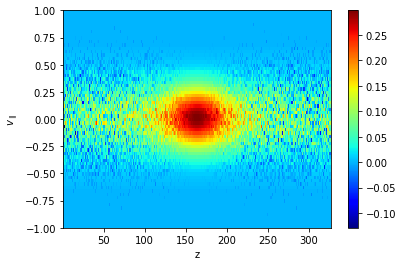

In [13]:
import matplotlib.pyplot as plt

Lv = 8
Nbin = 256
fdens = np.zeros((Nbin, Nbin))

dz_bin = Lz/Nbin
dv_bin = Lv/Nbin
z_bin = np.linspace(0, Lz, Nbin + 1)
z_bin = np.delete(z_bin, -1) + dz_bin/2
v_bin = np.linspace(-Lv/2, Lv/2, Nbin + 1)
v_bin = np.delete(v_bin, -1) + dv_bin/2

Zedges = np.linspace(0, Lz, Nbin + 1)
Vedges = np.linspace(-Lv/2, Lv/2, Nbin + 1)
ZZ, VV = np.meshgrid(z_bin, v_bin)
binVol = dz_bin*dv_bin



Zbin = np.digitize(particles[:, 0], Zedges) - 1
Vbin = np.digitize(particles[:, 3], Vedges) - 1

for i in range(0, Nbin):
    fdens[:, i] = np.bincount(Vbin[np.where(Zbin == i)[0]], particles[np.where(Zbin == i)[0], 4], Nbin)

fdens = fdens/(Np*binVol)


plt.pcolor(ZZ, VV, fdens + control*Maxwell(0, 0, VV)*2*np.pi*wperp**2, cmap = 'jet')
plt.colorbar()
plt.ylim((-1, 1))
plt.xlabel('z')
plt.ylabel('$v_\parallel$')